<a href="https://colab.research.google.com/github/EwoutH/CS4195-Twitter-network-sentience/blob/main/CS4195_Twitter_network_sentience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initial notebook

Dataset: https://www.kaggle.com/datasets/kazanova/sentiment140

In [303]:
import networkx as nx
import csv
import pandas as pd
from datetime import datetime
import re
from itertools import combinations
from ast import literal_eval

pd.set_option('display.max_columns', None)

### Get dataset

In [304]:
df = pd.read_csv(r'data\\training.1600000.processed.noemoticon.csv',delimiter=',', encoding='latin-1')
df.columns = ['target','ids','date','flag','user','text']
print(df.head(3))

   target         ids                          date      flag           user  \
0       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY  scotthamilton   
1       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY       mattycus   
2       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY        ElleCTF   

                                                text  
0  is upset that he can't update his Facebook by ...  
1  @Kenichan I dived many times for the ball. Man...  
2    my whole body feels itchy and like its on fire   


### Analyse the hashtags

In [305]:
print(len(df.loc[df['text'].str.contains("#")]))

36812


Not enough hashtags ?

### Pre-processing

In [388]:
# keep a part of the dataset (otherwise too computationally expensive)
df_pre = df.iloc[0:30000]

# keep usefull columns
df_pre = df_pre[['ids','target','date','user','text']]

# string date to date time
# remove time zone as it's always the same
df_pre['date'] = df_pre['date'].str.replace("PDT", "")
df_pre['date'] = pd.to_datetime(df_pre['date'], format="%a %b %d %H:%M:%S  %Y")

print(df_pre.head(3))
print(df_pre.dtypes)

          ids  target                date           user  \
0  1467810672       0 2009-04-06 22:19:49  scotthamilton   
1  1467810917       0 2009-04-06 22:19:53       mattycus   
2  1467811184       0 2009-04-06 22:19:57        ElleCTF   

                                                text  
0  is upset that he can't update his Facebook by ...  
1  @Kenichan I dived many times for the ball. Man...  
2    my whole body feels itchy and like its on fire   
ids                int64
target             int64
date      datetime64[ns]
user              object
text              object
dtype: object


## Try something with the hashtags

In [389]:
#only keep rows with hashtags
df_ht = df_pre.loc[df_pre['text'].str.contains("#")]
df_ht.reset_index(inplace=True)

#create new columns that is a list of all the hashtags in the text (usually there is only one hashtag)
pattern = r'#(\w+)'
df_ht['hashtag'] = df_ht['text'].apply(lambda x: re.findall(pattern, x))
print(df_ht)

     index         ids  target                date             user  \
0       82  1467834265       0 2009-04-06 22:25:54  mike_webster_au   
1      174  1467856821       0 2009-04-06 22:31:48        mydwynter   
2      189  1467859558       0 2009-04-06 22:32:30        tchviolin   
3      192  1467859922       0 2009-04-06 22:32:35       Karmatical   
4      330  1467895481       0 2009-04-06 22:42:08    RedTheTrucker   
5      367  1467905378       0 2009-04-06 22:44:52     raymondroman   
6      399  1467913111       0 2009-04-06 22:46:57           nssmom   
7      425  1467918728       0 2009-04-06 22:48:35          TidyCat   
8      581  1467960196       0 2009-04-06 23:00:22       ilovedanah   
9      639  1467972262       0 2009-04-06 23:03:39    Smith_Cameron   
10     755  1467998983       0 2009-04-06 23:11:21      grantzobell   
11    1002  1468060375       0 2009-04-06 23:30:10       BrandesAsh   
12    1030  1468064945       0 2009-04-06 23:31:30        mericlese   
13    

C:\Users\marti\AppData\Local\Temp\ipykernel_9372\2918791120.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ht['hashtag'] = df_ht['text'].apply(lambda x: re.findall(pattern, x))


### Create the network based on the hashtags

In [447]:
# create list of tuples for each unique hashtag ht as (ht,w) where w is the number of times they were used in a tweet with another hashtag
all_hashtags = []
for ht_list in df_ht['hashtag'].values:
    for ht in ht_list:
        if ht not in all_hashtags:
            all_hashtags.append([ht,0])
print(all_hashtags)

# returns the hashtags that are common in the two hashtag lists ht1 and ht2
def share_hashtag(ht1,ht2):
    common_hashtag = []
    for element in ht1:
        if element in ht2:
            common_hashtag.append(element)
                    
    return common_hashtag

# increase the number of times an hashtag was used if it is used in a tweet with another hashtag
def increase_ht_size(ht):
    for h1 in all_hashtags:
        for h2 in ht:
            if h1[0]==h2:
                h1[1]+=1
                break
    return all_hashtags

# check whether there already exists a row with same pair of hashtags
def edge_already_exists(new_df,ht1,ht2):
    for _, row in new_df.iterrows():
        if (row['hashtag1']==ht1 and row['hashtag2']==ht2) or (row['hashtag1']==ht2 and row['hashtag2']==ht1):
            return row
    return None

[['itm', 0], ['therapyfail', 0], ['fb', 0], ['TTSC', 0], ['24', 0], ['gayforpeavy', 0], ['FML', 0], ['3', 0], ['camerafail', 0], ['fb', 0], ['travian', 0], ['wow', 0], ['art', 0], ['fail', 0], ['KrispyKreme', 0], ['fb', 0], ['24', 0], ['the', 0], ['twitter', 0], ['fail', 0], ['CNN', 0], ['1', 0], ['Kulula', 0], ['surface', 0], ['c25k', 0], ['drupal', 0], ['epicfail', 0], ['rails', 0], ['mhbigcatch', 0], ['stuckrecord', 0], ['twitteriffic', 0], ['startrek', 0], ['earthquake', 0], ['php', 0], ['poken', 0], ['error', 0], ['tracy', 0], ['fb', 0], ['dwsr', 0], ['Italy', 0], ['Earthquake', 0], ['fantasysurfer', 0], ['titsuptuesday', 0], ['N85', 0], ['heyxboxlive', 0], ['House', 0], ['babypunch', 0], ['cob', 0], ['ticket', 0], ['fb', 0], ['fb', 0], ['terremoto', 0], ['earthquake', 0], ['italy', 0], ['fail', 0], ['itm', 0], ['AutomationAtaCost', 0], ['gsoc', 0], ['rockbox', 0], ['niceweather', 0], ['Berlin', 0], ['goodlife', 0], ['Ambients', 0], ['theinbetweeners', 0], ['Twilight', 0], ['Summe

In [448]:
# method that handles creating a new row in the new dataframe
def new_row(new_df,shared_hashtags,tweets):
    # increase hashtags node size cause used in multiple tweets
    for ht in shared_hashtags:
        all_hashtags = increase_ht_size(ht)
    # if two tweets share more than one hashtag, add edge between these hashtags
    if len(shared_hashtags)>=2:
        # do it for every combination of these hashtags
        for comb in list(combinations(shared_hashtags, 2)):
            ht1 = comb[0]
            ht2 = comb[1]
            row = edge_already_exists(new_df,ht1,ht2)
            #row does not exist
            if row is None :
                new_row = pd.DataFrame({'hashtag1':comb[0], 'hashtag2':comb[1], 'tweets_ids':[tweets]})
                new_df = pd.concat([new_df, new_row], axis=0, ignore_index=True)
            #row exists
            else:
                new_df['tweets_ids'].loc[row,['column-tweets_ids']] = new_df.loc[row,['column-tweets_ids']].exten(tweets)
    
    return new_df,all_hashtags


In [449]:
#new dataframe that will store the list of tweets of every pair of hashtags that are used in the same tweets
new_df = pd.DataFrame(columns=['hashtag1','hashtag2', 'tweets_ids'])

for i in range(df_ht.shape[0]):
    for j in range(i + 1, df_ht.shape[0]):
        shared_hashtags = share_hashtag(df_ht.iloc[i]['hashtag'],df_ht.iloc[j]['hashtag'])
        if len(shared_hashtags)>0:
            new_df,all_hashtags = new_row(new_df,shared_hashtags,[df_ht.iloc[i]['ids'],df_ht.iloc[j]['ids']])


In [451]:
print(new_df,'\n',all_hashtags)

  hashtag1 hashtag2                tweets_ids
0   liquor   Easter  [1468947202, 1468950206]
1  ASOT400  asot400  [1557840198, 1558084768] 
 [['itm', 0], ['therapyfail', 0], ['fb', 0], ['TTSC', 0], ['24', 0], ['gayforpeavy', 0], ['FML', 0], ['3', 7], ['camerafail', 0], ['fb', 0], ['travian', 0], ['wow', 0], ['art', 0], ['fail', 0], ['KrispyKreme', 0], ['fb', 0], ['24', 0], ['the', 0], ['twitter', 0], ['fail', 0], ['CNN', 0], ['1', 396], ['Kulula', 0], ['surface', 0], ['c25k', 0], ['drupal', 0], ['epicfail', 0], ['rails', 0], ['mhbigcatch', 0], ['stuckrecord', 0], ['twitteriffic', 0], ['startrek', 0], ['earthquake', 0], ['php', 0], ['poken', 0], ['error', 0], ['tracy', 0], ['fb', 0], ['dwsr', 0], ['Italy', 0], ['Earthquake', 0], ['fantasysurfer', 0], ['titsuptuesday', 0], ['N85', 0], ['heyxboxlive', 0], ['House', 0], ['babypunch', 0], ['cob', 0], ['ticket', 0], ['fb', 0], ['fb', 0], ['terremoto', 0], ['earthquake', 0], ['italy', 0], ['fail', 0], ['itm', 0], ['AutomationAtaCost', 0], ['gs

###  Create networks

In [493]:
G = nx.Graph()
counter=0
for ht in all_hashtags:
    G.add_node(ht[0], size = ht[1])
    counter+=1
print(counter)

print(len(G.nodes))

for i in range(len(G.nodes)):
    for j in range(i+1,len(G.nodes)):
        n1 = list(G.nodes)[i]
        n2 = list(G.nodes)[j]
        row = edge_already_exists(new_df,n1,n2)
        #row exists
        if row is not None:
            G.add_edge(n1,n2,length=len(row['tweets_ids']))

print(len(G.nodes))

628
353
353


# !!!!!! I don't understand why not all the nodes are created

2
628


ValueError: s must be a scalar, or float array-like with the same size as x and y

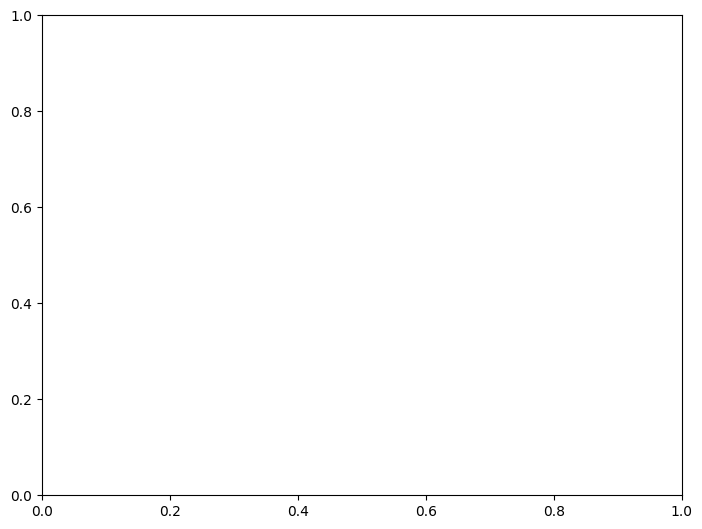

In [492]:
print(len(all_hashtags[625]))
print(len([x[1] for x in all_hashtags]))
nx.draw(G,node_size = all_hashtags,alpha=0.5)